### Import

In [1]:
import tensorflow as tf
# tf 2.0부터 keras는 tensorflow의 공식 API
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers

import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_row', 40000)
pd.set_option('display.max_column', 10000)

import os
from os.path import join
import sqlite3
import glob
import csv

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Data

In [3]:
path = "scc/*" #-------------------------자신의 db파일이 있는 폴더로 수정---------------------------
file_list =  glob.glob(path)
file_list_db = [file for file in file_list if file.endswith(".db")]
print ("file_list: {}".format(file_list_db))
len(file_list_db)
# EventCode03이 일어났을 당시의 초당 주행기록 가져오기

time_slice = 3

temp1 = np.zeros((1,time_slice,10)) # srcrec_df2 초기화

srcrec_df2 =temp1 # 연결한 db들의 x data 저장소
srcrec_df4 = pd.DataFrame() # 연결한 db들의 y data 저장소

for i in range (0,len(file_list_db)):
    # event 파일 가져오기
    f = open('src/event.csv') #-------------------------자신의 event파일이 있는 폴더로 수정---------------------------
    csvReader = csv.reader(f)
    # db연결
    conn = sqlite3.connect(file_list_db[i])
    c = conn. cursor()
    # event 테이블 유무 확인 후, 있으면 제거
    c.execute('Drop Table If Exists event')
    # event 테이블 생성
    c.execute("create table event(CAR_RECDRV_KEY integer, EVENT_CODE text, EVENT_STDT text, EVENT_ENDT text)")
    # csv 파일 읽어 온 데이터 insert
    for row in csvReader:
        if row[7] == "EVENT_CODE":
            continue
        sql1 = "insert into event (CAR_RECDRV_KEY,EVENT_CODE, EVENT_STDT, EVENT_ENDT) values (?,?,?,?)"
        key= int(row[1])
        #key 추출
        if key != int(file_list_db[i][4:11]): #src에 자신의 db파일이 있어야함, 아니면 인덱스 수정할 것
            continue
        code = (row[7])
        #event 추출
        if code[-11:] != "EventCode03":
            continue
        stdt = (row[8])
        endt = (row[9])
        c.execute(sql1,(key,code,stdt,endt))
    #트랜잭션 저장
    conn.commit()
    #event03 뽐기 query 실행
    sql2 = 'SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcAPS,\
    SRCREC.srcGyroValue, SRCREC.srcRPM, SRCREC.srcTPS, SRCREC.srcMAF, SRCREC.srcEngineLoad, ifnull(EVENT_CODE, "0") FROM SRCREC LEFT OUTER JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s)\
     AND strftime("%Y%m%d%H%M%S",e)'
    query =  c.execute(sql2)
    cols = [column[0] for column in query.description]
    srcrec_df = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    
    # 슬라이딩 윈도우 적용
    srcrec_df = srcrec_df.iloc[100:]
    srcred_list =  srcrec_df.values
    seq_len = time_slice
    data_matrix=[]
    for i in range(0, len(srcred_list)-seq_len+1): # data를 겹친다. 0 1 2 3 4 5 -> 1 2 3 4 5 6
        tmp_data = srcrec_df[i:i+seq_len]
        data_matrix.append(tmp_data)
    data_matrix_np = np.array(data_matrix)
   
    if len(data_matrix_np)==0:
        continue
    # 각 db의 슬라이딩 적용한 x data들 합치기
    srcrec_df2 = np.concatenate([srcrec_df2,data_matrix_np])
    
    # y data 뽑아오기
    sql3 = 'SELECT ifnull(EVENT_CODE, "0") FROM SRCREC LEFT OUTER JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s)\
     AND strftime("%Y%m%d%H%M%S",e)'
    query =  c.execute(sql3)
    cols = [column[0] for column in query.description]
    srcrec_df3 = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    
    # 슬라이딩 적용으로 인해 필요없는 y data 제거
    srcrec_df3 = srcrec_df3.iloc[100 + time_slice - 1:] 
    
    # 각 db의 슬라이딩 적용한 y data들 합치기
    srcrec_df4 = pd.concat([srcrec_df4, srcrec_df3], ignore_index=True)
    
    #db 연결 종료
    c.close()
    conn.close()
    #파일 연결 종료
    f.close()
# srcrec_df2 : x data
# srcrec_df4 : y data
print(srcrec_df2.shape)
print(srcrec_df4.shape)

file_list: ['scc/2875311.db', 'scc/2872704.db', 'scc/2866021.db', 'scc/2876037.db', 'scc/2878804.db', 'scc/2871081.db', 'scc/2872996.db', 'scc/2866635.db', 'scc/2870370.db', 'scc/2864272.db', 'scc/2860462.db', 'scc/2872551.db', 'scc/2873898.db', 'scc/2882095.db', 'scc/2870347.db', 'scc/2879366.db', 'scc/2867198.db', 'scc/2861566.db', 'scc/2867677.db', 'scc/2870341.db', 'scc/2872611.db', 'scc/2866579.db', 'scc/2871080.db', 'scc/2867896.db', 'scc/2870343.db', 'scc/2874288.db', 'scc/2859490.db', 'scc/2867101.db', 'scc/2860307.db', 'scc/2879724.db', 'scc/2861561.db', 'scc/2873001.db', 'scc/2873000.db', 'scc/2869545.db', 'scc/2875118.db', 'scc/2878582.db', 'scc/2878874.db', 'scc/2863131.db', 'scc/2874509.db', 'scc/2861971.db', 'scc/2866225.db', 'scc/2859348.db', 'scc/2860118.db', 'scc/2870025.db', 'scc/2869319.db', 'scc/2868357.db', 'scc/2867179.db', 'scc/2877877.db', 'scc/2860773.db', 'scc/2881230.db', 'scc/2879814.db', 'scc/2878702.db', 'scc/2868169.db', 'scc/2873460.db', 'scc/2859723.db'

(801025, 3, 10)
(801024, 1)


1. srcrec_df2를 초기화할 때 넣어준 0을 지움
2. 여러 컬럼 중 x data에 사용할 컬럼들을 걸러냄

In [4]:
x_data = srcrec_df2[1:,:,2:8]
len(x_data)

801024

In [5]:
y_data = srcrec_df4.values[: ,0]

y_data = pd.get_dummies(y_data).values

y_data = y_data[:,0]

where_0 = np.where(y_data == 0)
where_1 = np.where(y_data == 1)

y_data[where_0] = 1
y_data[where_1] = 0
#수정사항 categorical로 바꾸기
# y_data = to_categorical(y_data)

### Change from sequence x data to image 

In [6]:
# imaging time series as unthresholded recurrence plot
def r_plot(data,delay=0):
    #input datatype data : ndarray, 1xn, n-number of samples in each series
    #input datatype delay : int, delay embedding for RP formation, default value is 1
    #output datatype rp : ndarray, nxn, unthresholded recurrence plot for series
    transformed = np.zeros([2,len(data)-delay])
    transformed[0,:] = data[0:len(data)-delay]
    transformed[1,:] = data[delay:len(data)]
    rp = np.zeros([len(data)-delay,len(data)-delay])
    for i in range(len(rp)):
        temp = np.tile(transformed[:,i],(len(rp),1)).T-transformed
        temp2 = np.square(temp)
        rp[i,:] = np.sum(temp2,axis=0)
    return np.array(rp).tolist()

In [7]:
import matplotlib.pyplot as plt

#RP embedding
total = []
for row in range(0, len(x_data)):
    RP=[]
    for col in range(0, len(x_data[row][0])):       
        toy_data=x_data[row,:,col]
        RP.append(r_plot(toy_data))
    total.append(RP)
    
total2 = []
for rp in total:
    RP2 = []
    myrp2 ={}
    for i in range(0, time_slice):
        myrp2[i] = np.zeros((time_slice,6))
    for rp_count in range(0, len(myrp2)):
        myrp = myrp2[rp_count]
        rp_mini_count=0;
        for rp_mini in rp:
            for index in range(0, len(rp_mini[0])):
                myrp[index][rp_mini_count] = rp_mini[rp_count][index]
            rp_mini_count = rp_mini_count+1
            
    for key, value in myrp2.items():
        RP2.append(value)
        
    total2.append(RP2)        

print(len(total2[0]))
print(len(total2[0][0]))
print(len(total2[0][0][0]))
x_data = total2

3
3
6


### make the 0 and 1 ratio the same

In [8]:
import math

yindex=0
y1index=0
x1_data = []
y1_data = []

print(len(y_data))
for ydata in y_data:
    if ydata == 1:
        x1_data.append(x_data[yindex])
        y1_data.append(y_data[yindex])
        y1index= y1index+1
    yindex = yindex+1
print(y1index)

yindex=0
y1getindex=0 #가져오는 데이터 카운트 
for ydata in y_data:
    if ydata == 0:
        if y1getindex == math.floor(y1index*1.5):# event: normal = 1 : 1.5
            break
        x1_data.append(x_data[yindex])
        y1_data.append(y_data[yindex])
        y1getindex= y1getindex+1
    yindex = yindex+1


801024
4706


In [9]:
x_data = np.array(x1_data)
y_data = np.array(y1_data)
print(x_data[:10])
print(x_data.shape)

[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [2.00000000e+00 0.00000000e+00 4.68795260e+03 1.76720000e+06 0.00000000e+00 0.00000000e+00]
   [2.88000000e+02 0.00000000e+00 3.21173208e+03 5.71220000e+06 4.42906696e+01 0.00000000e+00]]

  [[2.00000000e+00 0.00000000e+00 4.68795260e+03 1.76720000e+06 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [2.42000000e+02 0.00000000e+00 1.39156926e+02 1.12500000e+06 4.42906696e+01 0.00000000e+00]]

  [[2.88000000e+02 0.00000000e+00 3.21173208e+03 5.71220000e+06 4.42906696e+01 0.00000000e+00]
   [2.42000000e+02 0.00000000e+00 1.39156926e+02 1.12500000e+06 4.42906696e+01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


 [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [2.42000000e+02 0.00000000e+00 1.391569

In [10]:
len(x_data)

11765

### Hyper Parameters

In [11]:
learning_rate = 0.00005
training_epochs = 70
batch_size = 100

tf.random.set_seed(777) # weight 초기화용

### Creating a Checkpoint Directory

In [12]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'cnn_keras_sequential_eager_입력데이터 넣기 완료'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

### split train and test 

In [13]:
from sklearn.model_selection import train_test_split
trnx, tstx, trny, tsty = train_test_split(x_data, y_data, test_size=0.3, random_state=111)
# trnx = np.expand_dims(trnx,axis=-1)
# tstx = np.expand_dims(tstx,axis=-1)
print(len(trnx))
print(len(trny))

8235
8235


### Model Function

In [14]:
model = keras.Sequential()#이제 계층을 순차적으로 연결 가능
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                              input_shape=(time_slice, time_slice, 6)))# input_shape => 첫 layer에만 선언
model.add(keras.layers.MaxPool2D(padding='SAME'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
model.add(keras.layers.MaxPool2D(padding='SAME'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
model.add(keras.layers.MaxPool2D(padding='SAME'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation=tf.nn.relu))
#수정사항 2, softmax
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 3, 32)          1760      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [16]:
#수정사항 categorical
model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Nadam(lr = learning_rate,) , metrics=['accuracy'])

In [17]:
history = model.fit(x=trnx, y=trny, validation_data = (tstx, tsty), batch_size = batch_size, epochs = training_epochs)

Train on 8235 samples, validate on 3530 samples
Epoch 1/70
8235/8235 [==============================] - 3s 413us/sample - loss: 258.7893 - accuracy: 0.5212 - val_loss: 58.2278 - val_accuracy: 0.6244
Epoch 2/70
8235/8235 [==============================] - 1s 88us/sample - loss: 79.3312 - accuracy: 0.5664 - val_loss: 72.4700 - val_accuracy: 0.5241
Epoch 3/70
8235/8235 [==============================] - 1s 87us/sample - loss: 112.6458 - accuracy: 0.6070 - val_loss: 1011.2404 - val_accuracy: 0.4280
Epoch 4/70
8235/8235 [==============================] - 1s 85us/sample - loss: 423.1198 - accuracy: 0.5540 - val_loss: 39.2942 - val_accuracy: 0.6813
Epoch 5/70
8235/8235 [==============================] - 1s 88us/sample - loss: 311.1821 - accuracy: 0.5868 - val_loss: 66.1743 - val_accuracy: 0.6521
Epoch 6/70
8235/8235 [==============================] - 1s 84us/sample - loss: 93.9686 - accuracy: 0.6306 - val_loss: 90.2899 - val_accuracy: 0.6224
Epoch 7/70
8235/8235 [=============================

Epoch 55/70
8235/8235 [==============================] - 1s 85us/sample - loss: 71.4401 - accuracy: 0.7275 - val_loss: 88.8608 - val_accuracy: 0.6989
Epoch 56/70
8235/8235 [==============================] - 1s 84us/sample - loss: 32.8639 - accuracy: 0.7581 - val_loss: 5.9842 - val_accuracy: 0.7960
Epoch 57/70
8235/8235 [==============================] - 1s 86us/sample - loss: 37.8056 - accuracy: 0.7477 - val_loss: 5.8524 - val_accuracy: 0.7977
Epoch 58/70
8235/8235 [==============================] - 1s 84us/sample - loss: 92.7582 - accuracy: 0.7507 - val_loss: 966.0131 - val_accuracy: 0.5453
Epoch 59/70
8235/8235 [==============================] - 1s 86us/sample - loss: 503.2091 - accuracy: 0.6579 - val_loss: 162.0543 - val_accuracy: 0.7071
Epoch 60/70
8235/8235 [==============================] - 1s 88us/sample - loss: 68.4785 - accuracy: 0.7439 - val_loss: 20.1315 - val_accuracy: 0.7476
Epoch 61/70
8235/8235 [==============================] - 1s 84us/sample - loss: 13.0648 - accuracy:

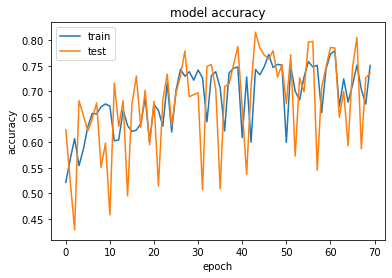

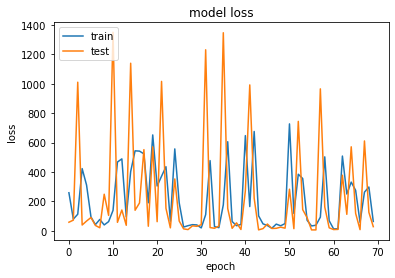

0.7348442
0.8155807


In [18]:
# summerize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summerize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test data 마지막 정확도
print(history.history['val_accuracy'][-1])
# test data 가장 높은 정확도
print(np.max(history.history['val_accuracy']))

In [19]:
#sigmoid
y_pred = model.predict(tstx, batch_size=batch_size)
a = 0
b = 0
c = 0
d = 0
for i in range(len(y_pred)) :
    if y_pred[i] < 0.5 : # event03 발생 X 추측
        if tsty[i] == 0 :
            a = a + 1
        else :
            b=b + 1
    else : # event03 발생 O 추측
        if tsty[i] == 1 : 
            c=c + 1
        else :
            d= d+ 1
print("실제 : 0, 예측 : 0 - ", a)
print("실제 : 1, 예측 : 0 - ", b)
print("실제 : 1, 예측 : 1 - ", c)
print("실제 : 0, 예측 : 1 - ", d)
print("총 개수 : ", len(y_pred))

#categorical
# a = 0
# b = 0
# c = 0
# d = 0
# for i in range(len(y_pred[:,0])) :
#     if y_pred[i,0] > y_pred[i,1] : # event03 발생 X
#         if tsty[i,1] == 0 :
#             a = a + 1
#         else :
#             b = b + 1
#     else :
#         if tsty[i,1] == 1 : # event03 발생 
#             c = c + 1
#         else :
#             d = d+ 1
# print("실제 : 0, 예측 : 0 -> ", a)
# print("실제 : 1, 예측 : 0 -> ", b)
# print("실제 : 1, 예측 : 1 -> ", c)
# print("실제 : 0, 예측 : 1 -> ", d)
# print("전체데이터 개수 : ", len(y_pred[:,0]))

실제 : 0, 예측 : 0 -  1347
실제 : 1, 예측 : 0 -  133
실제 : 1, 예측 : 1 -  1247
실제 : 0, 예측 : 1 -  803
총 개수 :  3530
